# Reinforcement Learning Projcet
In this notebook, there are the added runs and experiments shown in the paper

### Imports, initiate environment

In [ ]:
#uncomment if not downloaded.

!pip3 install box2d-py
!pip3 install gym[Box_2D]

In [ ]:
import gym
import sys
import random
import torch
import numpy as np
import itertools
from collections import namedtuple, deque
import matplotlib.pyplot as plt
#%matplotlib inline

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal


# python imports
from operator import itemgetter
import time


# Use GPU is possible else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('LunarLanderContinuous-v2')
print('State shape: ', env.observation_space.shape)
print('Number of Actions: ', env.action_space)

State shape:  (8,)
Number of Actions:  Box(-1.0, 1.0, (2,), float32)


### Universal parameters
some parameters are also specifically for the DQN variants 

In [ ]:
STATE_SIZE = env.observation_space.shape[0] #8
ACTION_SIZE = env.action_space.shape[0] # 2 - for continuous application
main_egine_actions = [-1.0, 0.33, 0.66, 1.0]
left_right_actions = [-1.0, 0, 1.0]
ACTIONS = list(itertools.product(main_egine_actions, left_right_actions))
DISCRETE_ACTION_SIZE = len(ACTIONS) # for discretization of action space by ACTIONS

#These parameters assume all actions has the same high-low
ACTION_HIGH = env.action_space.high#[0]
ACTION_LOW = env.action_space.low#[0]

# Define the agents hyperparameters, incl. Replay Memory

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64  # minibatch size
GAMMA = 0.99  # discount factor
TAU = 1e-3  # for soft update of target parameters
LR = 5e-4  # learning rate
UPDATE_EVERY = 4  # how often to update the network

ALPHA = 1
INITIAL_BETA = 0.4

### Helper functions

In [ ]:
#layer initializations
def init_layer(layer):
    size = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(size)
    return (-lim,lim)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0)
#copy model parameters from source to target        
def copy_params(source, target):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)
#print model parameters
def print_params(model):
    for name, param in self.policy_network.named_parameters():
        if param.requires_grad:
            print (name, param.data)
            
#seed the environment.
def init_seed(seed):
    #run this before any agent. checked to stabilize the randomness.
    env.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

#### Segment tree structure , helper for Prioritized Experience Replay (PER)
reduces computation time needed to calculate PER priorities 

In [ ]:
import operator


class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.
        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)

class LinearSchedule(object):
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
        """Linear interpolation between initial_p and final_p over
        schedule_timesteps. After this many timesteps pass final_p is
        returned.
        Parameters
        ----------
        schedule_timesteps: int
            Number of timesteps for which to linearly anneal initial_p
            to final_p
        initial_p: float
            initial output value
        final_p: float
            final output value
        """
        self.schedule_timesteps = schedule_timesteps
        self.final_p = final_p
        self.initial_p = initial_p

    def value(self, t):
        """See Schedule.value"""
        fraction = min(float(t) / self.schedule_timesteps, 1.0)
        return self.initial_p + fraction * (self.final_p - self.initial_p)

### Replay memory and Prioritized replay memory (PER)

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size,is_action_discrete=True):#, seed , action_size
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.buffer_size = buffer_size
        self.is_action_discrete = is_action_discrete
        
        self._index = 0
        self.memory = []
        #self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        #print (reward,np.array(reward))
        e = self.experience(state, action, reward, next_state, done)
        #self.memory.append(e)
        if self._index >= len(self.memory):
            self.memory.append(e)
        else:
            self.memory[self._index] = e
        self._index = (self._index + 1) % self.buffer_size
            

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        if self.is_action_discrete:
            actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        else:#action is continuous
            actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)
        #print (rewards,np.array[rewards])
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, buffer_size, batch_size, alpha, is_action_discrete = True):
        super(PrioritizedReplayBuffer,self).__init__(buffer_size, batch_size, is_action_discrete)
        self.alpha = alpha
        self.max_priority = 1.0
        #self.next_index =  0

        tree_size = 1
        while tree_size < buffer_size:
            tree_size *= 2
        
        self.sumtree = SumSegmentTree(tree_size)
        self.minsumtree = MinSegmentTree(tree_size)
        #self.max_priority = 1.0

    def add(self, state, action, reward, next_state, done):
        index = self._index
        super().add(state, action, reward, next_state, done)
        #print(self.next_index,self.sumtree._capacity)
        self.sumtree[index] = self.max_priority ** self.alpha
        self.minsumtree[index] = self.max_priority ** self.alpha
        #self.next_index = (self.next_index + 1) % self.buffer_size

    def sample_proportional(self):
        res = []
        p_total = self.sumtree.sum(0, len(self.memory) - 1)
        every_range_len = p_total / self.batch_size
        for i in range(self.batch_size):
          mass = random.random() * every_range_len + i * every_range_len
          idx = self.sumtree.find_prefixsum_idx(mass)
          res.append(idx)
        return res

    def sample(self,beta):
        """Randomly sample a batch of experiences from memory."""
        indexes = self.sample_proportional()
        
        weights = []
        p_min = self.minsumtree.min() / self.sumtree.sum()
        max_weight = (p_min * len(self.memory)) ** (-beta)

        for idx in indexes:
            p_sample = self.sumtree[idx] / self.sumtree.sum()
            weight = (p_sample * len(self.memory)) ** (-beta)
            weights.append(weight / max_weight)
        weights = torch.from_numpy(np.array(weights)).float().to(device)
        
        #print (indexes,weights)
        experiences = list(itemgetter(*indexes)(self.memory))
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)

        return (states, actions, rewards, next_states, dones, weights, indexes)

    def update_priorities(self,indexes, priorities):
        for index,priority in zip(indexes,priorities):
          self.sumtree[index] = priority ** self.alpha
          self.minsumtree[index] = priority ** self.alpha
          self.max_priority = max(self.max_priority,priority)

### Q-network for DQN, and Dueling Q-network for DuelingDQN

In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DuelingQNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(DuelingQNetwork, self).__init__()
        self.action_size = action_size
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        fc3_units = 32
        #value
        self.fc3_val = nn.Linear(fc2_units,fc3_units)
        self.fc4_val = nn.Linear(fc3_units,1)
        #advantage
        self.fc3_adv = nn.Linear(fc2_units,fc3_units)
        self.fc4_adv = nn.Linear(fc3_units,action_size)


    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        val = F.relu(self.fc3_val(x))
        val = self.fc4_val(val)

        adv = F.relu(self.fc3_adv(x))
        adv = self.fc4_adv(adv)

        x = val + adv - adv.mean(1).unsqueeze(1).expand(state.size(0), self.action_size)
        return x



### DQN agent, and Double DQN agent

In [ ]:
class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, prioritized_replay = False, alpha= None, beta = None,prioritized_replay_epsilon = 1e-6,dueling = False):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        if prioritized_replay:
          self.prioritized_replay = True
          self.alpha = alpha
          self.beta = beta
          self.prioritized_replay_epsilon = 0.
          # Replay memory
          self.memory = PrioritizedReplayBuffer(BUFFER_SIZE, BATCH_SIZE, alpha)
        else:
          self.prioritized_replay = False
          self.alpha = None
          self.beta = None
          self.prioritized_replay_epsilon = prioritized_replay_epsilon
          # Replay memory
          self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

        # Q-Network
        if dueling:
          self.qnetwork_local = DuelingQNetwork(state_size, action_size).to(device)
          self.qnetwork_target = DuelingQNetwork(state_size, action_size).to(device)
        else:
          self.qnetwork_local = QNetwork(state_size, action_size).to(device)
          self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0 

    def step(self, state, action, reward, next_state, done,t=0):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        #print(state, action, reward, next_state, done)
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) 
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                if self.prioritized_replay:
                    experiences = self.memory.sample(self.beta.value(t))
                else:
                    experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))


    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        if self.prioritized_replay:
            states, actions, rewards, next_states, dones, weights, indexes = experiences
        else:
            states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        #try this? loss = F.smooth_l1_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.prioritized_replay:
            #print(Q_targets.shape)
            #print(Q_expected.shape)
            td_errors = (Q_targets - Q_expected).squeeze()
            #print(td_errors.shape)
            #print(weights.shape)
            #print(weights.is_cuda,td_errors.is_cuda)
            new_prioritizes = weights.cpu()*np.abs(td_errors.detach().cpu()) + self.prioritized_replay_epsilon
            #print(new_prioritizes.shape)
            #print(len(new_prioritizes),len(indexes))
            #assert len(indexes == new_prioritizes)
            self.memory.update_priorities(indexes,new_prioritizes)
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)



class DDQNAgent(DQNAgent):
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        if self.prioritized_replay:
          states, actions, rewards, next_states, dones, weights, indexes = experiences
        else:
          states, actions, rewards, next_states, dones = experiences


        # Get max indicies from Q local model, then max predicted Q values (for next states) from target model
        Q_indicies_next = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        #print(Q_indicies_next.shape,Q_indicies_next)
        #print(self.qnetwork_target(next_states).detach().max(1)[0].shape,self.qnetwork_target(next_states).detach().max(1)[0])
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1,Q_indicies_next)
        #print(Q_targets_next.shape)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        #try this? loss = F.smooth_l1_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.prioritized_replay:
            td_errors = (Q_targets - Q_expected).squeeze()
            new_prioritizes = weights.cpu()*np.abs(td_errors.detach().cpu()) + self.prioritized_replay_epsilon
            self.memory.update_priorities(indexes,new_prioritizes)

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

### Soft Q-Network and Policy Network for Soft Actor Critic modules

In [ ]:
from torch.distributions.normal import Normal
      
class SoftQNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, hidden_units=64, init_w = 3e-3):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(SoftQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size+action_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, 1)
        
        #small init to layer weights
        #self.fc1.weight.data.uniform_(*init_layer(self.fc1))
        #self.fc2.weight.data.uniform_(*init_layer(self.fc2))
        self.fc3.weight.data.uniform_(-init_w,init_w)
        self.fc3.bias.data.uniform_(-init_w,init_w)
        
        #self.apply(init)

    def forward(self, state, action):
        """Build a network that maps state -> action values."""
        #x = torch.cat((state,action),dim=1)
        x = torch.cat([state,action],1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class PolicyNetwork(nn.Module):
    def __init__(self,state_size,action_size, hidden_units = 64, init_w=3e-3, log_std_min = -20, log_std_max = 2): #, action_limit
        super(PolicyNetwork,self).__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        #self.action_limit = action_limit
        
        self.fc1 = nn.Linear(state_size,hidden_units)
        self.fc2 = nn.Linear(hidden_units,hidden_units)
        
        self.mean_layer = nn.Linear(hidden_units, action_size)
        self.mean_layer.weight.data.uniform_(-init_w, init_w)
        self.mean_layer.bias.data.uniform_(-init_w, init_w)
        
        #small init to last layer weights
        self.log_std_layer = nn.Linear(hidden_units,action_size)
        self.log_std_layer.weight.data.uniform_(-init_w,init_w)
        self.log_std_layer.bias.data.uniform_(-init_w,init_w)
        
        #print(self.mean_layer,self.mean_layer.parameters())
        
    def forward(self,state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean_layer(x)
        log_std_unclamped = self.log_std_layer(x)
        log_std = torch.clamp(log_std_unclamped, self.log_std_min, self.log_std_max)
        #print (mean,log_std)
        return mean, log_std
    
    def sample(self,state,epsilon=1e-6):#deterministic = False):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal_distribution = Normal(mean,std)
        e = normal_distribution.rsample()
        action = torch.tanh(e)
        
        log_prob = normal_distribution.log_prob(e) - torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(1,keepdim=True)
        
        return action,log_prob
 

### Soft Actor-Critic  agent

In [ ]:
class SACAgent:
    def __init__(self, state_size, action_size, alpha, is_auto_alpha = True, q_lr = LR, policy_lr = LR, a_lr = LR, action_prior = "uniform"): #, action_range
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size
        self.action_range = [ACTION_LOW,ACTION_HIGH]
        
        self.alpha = alpha
        self.is_auto_alpha = is_auto_alpha
        self._action_prior = action_prior
        
        #for the train func. also can be upgraded later on to PER (right now we assume it is false)
        self.prioritized_replay = False
        
        self.q1_network = SoftQNetwork(self.state_size,self.action_size).to(device)
        self.q2_network = SoftQNetwork(self.state_size,self.action_size).to(device)
        self.q1_target = SoftQNetwork(self.state_size,self.action_size).to(device)
        self.q2_target = SoftQNetwork(self.state_size,self.action_size).to(device)
        self.policy_network = PolicyNetwork(self.state_size,self.action_size).to(device)
        

        copy_params(self.q1_network,self.q1_target)
        copy_params(self.q2_network,self.q2_target)
        
        self.q1_optimizer = optim.Adam(self.q1_network.parameters(),lr=q_lr)
        self.q2_optimizer = optim.Adam(self.q2_network.parameters(),lr=q_lr)
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(),lr=policy_lr)

        
        #for the auto-temperature
        if self.is_auto_alpha:
            #self.alpha = 1
            self.target_entropy = -torch.prod(torch.Tensor((action_size,)).to(device)).item()#-action_size
            self.log_alpha = torch.zeros(1,requires_grad=True, device = device)
            self.alpha_optimizer = optim.Adam([self.log_alpha],lr=a_lr)
            
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, is_action_discrete = False)
        #self.memory = BasicBuffer(BUFFER_SIZE)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0 
        
           
    def step(self, state, action, reward, next_state, done,t=0):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done) ##
        #self.memory.push(state, action, reward, next_state, done)
        #print(action,"makinta")
        # If enough samples are available in memory, get random subset and learn
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample() ###
            self.learn(experiences, GAMMA)
            
        #update step count
        self.t_step = (self.t_step + 1) % UPDATE_EVERY

    def act(self, state):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        #run state in policy net
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        #print(state)
        mean,log_std = self.policy_network.forward(state)
        std = log_std.exp()
        #print(state.is_cuda)
        #print(mean,log_std)
        #sample from dist
        normal_distribution = Normal(mean,std)
        e = normal_distribution.sample()
        action = torch.tanh(e)
        action = action.cpu().detach().squeeze(0).numpy()
        
        #rescale action
        
        #action = action * (self.action_range[1] - self.action_range[0]) / 2.0 + (self.action_range[1] + self.action_range[0]) / 2.0
        #return action 
        #rint (action)
        a = action * (self.action_range[1] - self.action_range[0]) / 2.0 +\
            (self.action_range[1] + self.action_range[0]) / 2.0
        #rint (a)
        return a
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        #states = torch.FloatTensor(states).to(device)
        #actions = torch.FloatTensor(actions).to(device)
        #rewards = torch.FloatTensor(rewards).to(device)
        #next_states = torch.FloatTensor(next_states).to(device)
        #dones = torch.FloatTensor(dones).to(device)
        #dones = dones.view(dones.size(0),-1) ###
        #print(states, actions, rewards, next_states, dones)
        #print (states.shape, actions.shape, rewards.shape, next_states.shape, dones.shape)
        
        next_actions, next_log = self.policy_network.sample(next_states)
        
        Q1_target_next = self.q1_target(next_states, next_actions)
        Q2_target_next = self.q2_target(next_states, next_actions)
        Q_targets_next = torch.min(Q1_target_next,Q2_target_next) - self.alpha * next_log
                 
        Q_targets = rewards + gamma * (Q_targets_next) * (1 - dones)
        
        Q_1 = self.q1_network.forward(states,actions)
        Q_2 = self.q2_network.forward(states,actions)
        
        #calc q-nets loss
        Q1_loss = F.mse_loss(Q_1,Q_targets.detach())
        Q2_loss = F.mse_loss(Q_2,Q_targets.detach())

        #update q-nets params
        self.q1_optimizer.zero_grad()
        Q1_loss.backward()
        self.q1_optimizer.step()
        
        self.q2_optimizer.zero_grad()
        Q2_loss.backward()
        self.q2_optimizer.step()
        
        actions_pred,log_pis = self.policy_network.sample(states)
        
        # Learn every UPDATE_EVERY time steps.
        #IS THIS THE RIGHT ORDER
        if self.t_step == 0:
            Q_min = torch.min(self.q1_network.forward(states,actions_pred),self.q2_network.forward(states,actions_pred))
            
            policy_loss = (self.alpha * log_pis - Q_min).mean()
            
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()

            # ------------------- update target network ------------------- #
            self.soft_update(self.q1_network, self.q1_target, TAU)     
            self.soft_update(self.q2_network, self.q2_target, TAU)  
        
        if self.is_auto_alpha:
            alpha_loss = (self.log_alpha * (- log_pis - self.target_entropy).detach()).mean()
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
            self.alpha = self.log_alpha.exp()
            
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param + (1.0 - tau) * target_param)


## Proximal Policy Optimization (PPO)
an on-policy algorithm, both discrete and continuous

## PPO Discrete Agent

In [ ]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

class ActorCriticDiscrete(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCriticDiscrete, self).__init__()

        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, action_dim),
                nn.Softmax(dim=-1)
                )
        
        # critic
        self.value_layer = nn.Sequential(
               nn.Linear(state_dim, 128),
               nn.ReLU(),
               nn.Linear(128, 64),
               nn.ReLU(),
               nn.Linear(64, 1)
               )
        
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device) 
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_layer(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy
        
class PPODiscreteAgent:
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.timestep = 0
        self.memory = Memory()
        
        self.policy = ActorCriticDiscrete(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCriticDiscrete(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self):   
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.memory.rewards), reversed(self.memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.stack(self.memory.states).to(device).detach()
        old_actions = torch.stack(self.memory.actions).to(device).detach()
        old_logprobs = torch.stack(self.memory.logprobs).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())

    def step(self, reward, done):
        self.timestep += 1 
        # Saving reward and is_terminal:
        self.memory.rewards.append(reward)
        self.memory.is_terminals.append(done)
        
        # update if its time
        if self.timestep % update_timestep == 0:
            self.update()
            self.memory.clear_memory()
            self.timstamp = 0

    def act(self, state):
        return self.policy_old.act(state, self.memory)

## PPO Continous Agent

In [ ]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

class ActorCriticContinuous(nn.Module):
    def __init__(self, state_dim, action_dim, action_std):
        super(ActorCriticContinuous, self).__init__()
        # action mean range -1 to 1
        self.actor =  nn.Sequential(
                nn.Linear(state_dim, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, action_dim),
                nn.ReLU()
                )
        # critic
        self.critic = nn.Sequential(
                nn.Linear(state_dim, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
                )
        self.action_var = torch.full((action_dim,), action_std*action_std).to(device)

    
    def act(self, state, memory):
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(action_logprob)
        
        return action.detach()
    
    def evaluate(self, state, action):   
        action_mean = self.actor(state)
        
        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy

class PPOContinuousAgent:
    def __init__(self, state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.time_step = 0
        self.memory = Memory()
        
        self.policy = ActorCriticContinuous(state_dim, action_dim, action_std).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        
        self.policy_old = ActorCriticContinuous(state_dim, action_dim, action_std).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy_old.act(state, self.memory).cpu().data.numpy().flatten()
    
    def update(self):
        # Monte Carlo estimate of rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.memory.rewards), reversed(self.memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.memory.states).to(device), 1).detach()
        old_actions = torch.squeeze(torch.stack(self.memory.actions).to(device), 1).detach()
        old_logprobs = torch.squeeze(torch.stack(self.memory.logprobs), 1).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())

    def step(self, reward, done):
        self.time_step += 1
        # Saving reward and is_terminals:
        self.memory.rewards.append(reward)
        self.memory.is_terminals.append(done)
        
        # update if its time
        if self.time_step % update_timestep == 0:
            self.update()
            self.memory.clear_memory()
            self.time_step = 0

    def act(self, state):
        return self.select_action(state)


### Train function and added parameters

In [ ]:
def train(agent, n_episodes=100, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, agent_type = "DQN"):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        agent_type (str): determines agent's type (q-learning , sac)
    """
    scores = []  # list containing scores from each episode
    avg_scores = [] # list contating avg scores 
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start  # initialize epsilon
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            #choose an action
            if agent_type == "SAC":
                action = agent.act(state)
            elif agent_type == "DQN":
                action_index = agent.act(state, eps)
                action= ACTIONS[action_index]
            elif agent_type == "PPO_DISCRETE":
                action_index = agent.act(state)
                action= ACTIONS[action_index]
            elif agent_type == "PPO_CONTINUOUS":
                action = agent.act(state)
            #do action in environment
            next_state, reward, done, _ = env.step(action)
            
            #observe and learn (by the agent)
            if agent_type == "SAC":
                agent.step(state,action,reward,next_state,done)
            elif agent_type == "DQN":
                if agent.prioritized_replay:
                    agent.step(state, action_index, reward, next_state, done,i_episode)
                else:
                    agent.step(state, action_index, reward, next_state, done)
            elif agent_type == "PPO_DISCRETE" or "PPO_CONTINUOUS":
                 agent.step(reward, done)
            #accumulate score and move to next state
            state = next_state
            score += reward
            
            #stop episode if done
            if done:
                break
        
        
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        avg_scores.append(np.mean(scores_window)) # save current avg score
        
        if agent_type == "DQN":
            eps = max(eps_end, eps_decay * eps)  # decrease epsilon
        
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                         np.mean(scores_window)))
        
            #torch.save(agent.state_dict(), '/saved')
            break
        
    return scores,avg_scores

In [ ]:
TOTAL_TIMESTEPS = 1500 #max timesteps, this should be high enough so convergence happens.
RUNS = 3 #how many runs of each agent (with different seed)
BETA = LinearSchedule(TOTAL_TIMESTEPS,1.0,INITIAL_BETA) # beta schedule for prioritzed replay

#### Initialize DQN agents

In [ ]:
#agents = [DQN,DQN_PER,DQN_DUELING,DQN_DUELING_PER,DDQN,DDQN_PER,DDQN_DUELING,DDQN_DUELING_PER]
agents_names = ['DQN','DQN_PER','DQN_DUELING','DQN_DUELING_PER','DDQN','DDQN_PER','DDQN_DUELING','DDQN_DUELING_PER']

#### save model scores, averages and time to train

In [ ]:
scores = []
avg_scores = []
times = []

### Train DQN agents

In [ ]:
for name in agents_names:
    for i in range(1,RUNS+1):
       #if i == 1 and name == 'DQN':
       #    continue
        init_seed(i)
        if name == 'DQN':
            agent = DQNAgent(STATE_SIZE,DISCRETE_ACTION_SIZE)
        elif name == 'DQN_PER':
            agent = DQNAgent(STATE_SIZE,DISCRETE_ACTION_SIZE,prioritized_replay =True, alpha=ALPHA, beta = BETA)
        elif name == 'DQN_DUELING':
            agent = DQNAgent(STATE_SIZE,DISCRETE_ACTION_SIZE,dueling = True)
        elif name == 'DQN_DUELING_PER':
            agent = DQNAgent(STATE_SIZE,DISCRETE_ACTION_SIZE,prioritized_replay =True,dueling = True, alpha=ALPHA, beta = BETA)
        elif name == 'DDQN':
            agent = DDQNAgent(STATE_SIZE,DISCRETE_ACTION_SIZE)
        elif name == 'DDQN_PER':
            agent = DDQNAgent(STATE_SIZE,DISCRETE_ACTION_SIZE,prioritized_replay =True, alpha=ALPHA, beta = BETA)
        elif name == 'DDQN_DUELING':
            agent = DDQNAgent(STATE_SIZE,DISCRETE_ACTION_SIZE,dueling = True)
        elif name == 'DDQN_DUELING_PER':
            agent = DDQNAgent(STATE_SIZE,DISCRETE_ACTION_SIZE,prioritized_replay =True,dueling = True, alpha=ALPHA, beta = BETA)
        
        print(name,i)
        #append to scores
        start = time.time()
        score, avg_score = train(agent,TOTAL_TIMESTEPS)
        end = time.time()
        
        scores.append(score)
        avg_scores.append(avg_score)
        times.append(end - start)
        
        #save model
        torch.save(agent.qnetwork_local.state_dict(), name + '_'+str(i)+'.pt')

DDQN 1
Episode 100	Average Score: -405.01
Episode 200	Average Score: -220.81
Episode 300	Average Score: -113.75
Episode 400	Average Score: -51.313
Episode 500	Average Score: 53.033
Episode 600	Average Score: 111.48
Episode 700	Average Score: 150.77
Episode 800	Average Score: 148.34
Episode 891	Average Score: 201.38
Environment solved in 791 episodes!	Average Score: 201.38
DDQN 2
Episode 100	Average Score: -409.88
Episode 200	Average Score: -191.48
Episode 300	Average Score: -78.685
Episode 400	Average Score: -69.55
Episode 500	Average Score: -71.45
Episode 600	Average Score: 28.597
Episode 700	Average Score: 130.18
Episode 800	Average Score: 153.10
Episode 900	Average Score: 151.58
Episode 940	Average Score: 200.27
Environment solved in 840 episodes!	Average Score: 200.27
DDQN 3
Episode 100	Average Score: -387.25
Episode 200	Average Score: -304.18
Episode 300	Average Score: -111.43
Episode 400	Average Score: -65.586
Episode 500	Average Score: -21.42
Episode 600	Average Score: 153.20
Ep

#### Save DQN info

In [ ]:
import json
with open('scores.json',"w") as file:
    json.dump(scores,file,indent = 2)
with open('avg_scores.json',"w") as file:
    json.dump(avg_scores,file,indent = 2)
with open('times.json',"w") as file:
    json.dump(times,file,indent = 2)

Average time calculations

In [ ]:
lens = []
for i in range(len(avg_scores)):
    lens.append(len(avg_scores[i]))
lens

In [ ]:
avg_time = []
avg_len = []
for i in range(0,len(lens),3):
    avg_len.append((lens[i]+lens[i+1]+lens[i+2])/3)
    avg_time.append((times[i]+times[i+1]+times[i+2])/3)
print(avg_time)
print(avg_len)

### Initialize policy agents
first parameters, then agents. notice TAU and UPDATE_EVERY has changed

In [ ]:
#Params for SAC. Alpha is 0.2 acc. to paper, TAU and UPDATE_EVERY are changed.
BATCH_SIZE = 64
LR = 5e-4
ALPHA_SAC = 0.2
TAU = 0.01
UPDATE_EVERY = 2
#BUFFER_SIZE = 100000#int(1e6) 

*italicized text*### Train SAC and PPO agents

In [ ]:
sac_scores = []
sac_avg_scores = []
sac_times = []
for i in range(1,RUNS+1):
    init_seed(i)
    SAC = SACAgent(STATE_SIZE,ACTION_SIZE,ALPHA_SAC)
    start = time.time()
    score, avg_score = train(SAC,TOTAL_TIMESTEPS,agent_type="SAC")
    end = time.time()
    sac_scores.append(score)
    sac_avg_scores.append(avg_score)
    sac_times.append(end - start)
    torch.save(SAC.policy_network.state_dict(), "SAC_"+str(i)+".pt")

Episode 100	Average Score: -87.45
Episode 200	Average Score: -37.47
Episode 300	Average Score: -10.97
Episode 400	Average Score: 164.18
Episode 430	Average Score: 200.25
Environment solved in 330 episodes!	Average Score: 200.25
Episode 100	Average Score: -110.14
Episode 200	Average Score: -20.839
Episode 300	Average Score: 145.27
Episode 323	Average Score: 200.08
Environment solved in 223 episodes!	Average Score: 200.08
Episode 100	Average Score: -196.08
Episode 200	Average Score: -125.76
Episode 300	Average Score: -76.430
Episode 400	Average Score: -46.46
Episode 500	Average Score: -30.53
Episode 600	Average Score: 21.954
Episode 700	Average Score: 164.60
Episode 800	Average Score: 192.90
Episode 808	Average Score: 201.71
Environment solved in 708 episodes!	Average Score: 201.71


In [ ]:
import json
with open('sacscores.json',"w") as file:
    json.dump(sac_scores,file,indent = 2)
with open('sacavg_scores.json',"w") as file:
    json.dump(sac_avg_scores,file,indent = 2)
with open('sactimes.json',"w") as file:
    json.dump(sac_times,file,indent = 2)

##PPO discrete

In [ ]:
ppo_scores = []
ppo_avg_scores = []
ppo_times = []

state_dim = env.observation_space.shape[0]
action_dim = len(ACTIONS) 
solved_reward = 200         # stop training if avg_reward > solved_reward
log_interval = 100          # print avg reward in the interval
max_episodes = 2000        # max training episodes
max_timesteps = 300       # max timesteps in one episode
n_latent_var = 256           # number of variables in hidden layer
update_timestep = 1200      # update policy every n timesteps
lr = 0.002
betas = (0.9, 0.999)
gamma = 0.99                # discount factor
K_epochs = 4                # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
random_seed = 1 

for i in range(1,RUNS+1):
    init_seed(i)
    PPO = PPODiscreteAgent(state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip)
    start = time.time()
    score, avg_score = train(PPO,TOTAL_TIMESTEPS,agent_type="PPO_DISCRETE")
    end = time.time()
    ppo_scores.append(score)
    ppo_avg_scores.append(avg_score)
    ppo_times.append(end - start)
    torch.save(PPO.policy.state_dict(), "PPO_"+str(i)+".pt")
'''
ppo_scores = []
for i in range(1,RUNS+1):
    init_seed(i)
    ppo_scores.append(train(PPO,TOTAL_TIMESTEPS,agent_type="PPO"))
    torch.save(PPO.*policy_network.state_dict(), "PPO_"+str(i)+".pt")
'''

##PPO continous

In [ ]:
ppo_scores = []
ppo_avg_scores = []
ppo_times = []

solved_reward = 200         # stop training if avg_reward > solved_reward
log_interval = 1           # print avg reward in the interval
max_episodes = 2000        # max training episodes
max_timesteps = 300        # max timesteps in one episode

update_timestep = 1200      # update policy every n timesteps
action_std = 0.5            # constant std for action distribution (Multivariate Normal)
K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr = 0.0003                 # parameters for Adam optimizer
betas = (0.9, 0.999)

random_seed = 1

for i in range(1,RUNS+1):
    init_seed(i)
    PPO =  PPOContinuousAgent(STATE_SIZE, ACTION_SIZE, action_std, lr, betas, gamma, K_epochs, eps_clip)
    start = time.time()
    score, avg_score = train(PPO,TOTAL_TIMESTEPS,agent_type="PPO_CONTINUOUS")
    end = time.time()
    ppo_scores.append(score)
    ppo_avg_scores.append(avg_score)
    ppo_times.append(end - start)
    torch.save(PPO.policy.state_dict(), "PPO_"+str(i)+".pt")
'''
ppo_scores = []
for i in range(1,RUNS+1):
    init_seed(i)
    ppo_scores.append(train(PPO,TOTAL_TIMESTEPS,agent_type="PPO"))
    torch.save(PPO.*policy_network.state_dict(), "PPO_"+str(i)+".pt")
'''

### Print graphs

In [ ]:
def print_graph(name,i,clr='blue'): 
    plt.plot(np.arange(len(scores[3*i])), scores[3*i], label= name,color = clr,alpha=0.3)
    plt.plot(np.arange(len(avg_scores[3*i])), avg_scores[3*i], label=name + ' average',color = clr)
    #plt.figure().add_subplot(111).text(3,8,len(scores[i]))
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend()
    plt.show()  

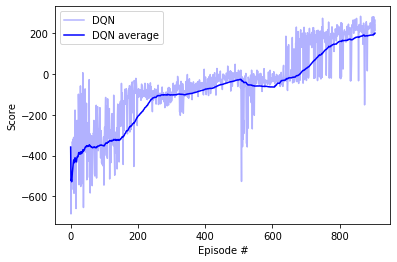

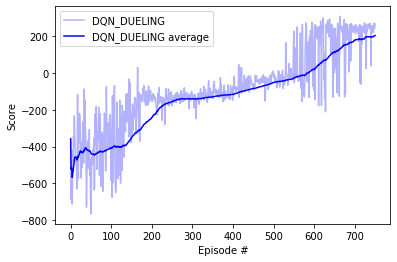

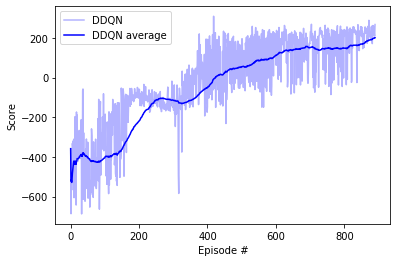

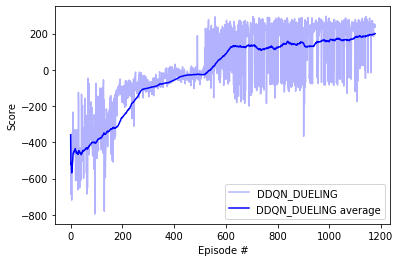

In [ ]:
names = ['DQN','DQN_DUELING','DDQN','DDQN_DUELING']
for i in range(4):
    print_graph(names[i],i)

In [ ]:
# func that can average easily.
#a = np.convolve(scoresSAC64, np.ones(100)/100, mode='valid')